# Ant Colony Optimisation

### A whirlwind tour of bio-inspired computing algorithms

#### Quentin Caudron

The [ant colony optimisation](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms) (ACO) algorithm is primarily used to find paths through graphs. As a subset of [swarm intelligence](https://en.wikipedia.org/wiki/Swarm_intelligence) methods, ACO relies on the [emergence](https://en.wikipedia.org/wiki/Emergence) of complex behaviours from the interactions of simple agents.

### The inspiration

In their search for food, certain species of ant may begin by randomly walking around. When food is found, the ant will return to the nest, leaving behind it a trail of pheromones that other ants can follow. 

In [35]:
import os
import shutil
import subprocess
import numpy as np
from scipy.sparse import dok_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from tqdm import tnrange

In [2]:
# Pull London Underground data
# https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/CSV
stations = pd.read_csv("data/london_tube_latlong.csv")
lines = pd.read_csv("data/london_tube_lines.csv")

# Construct adjacency matrix
A = np.zeros((stations.id.max()+1, stations.id.max()+1))
for station1, station2 in zip(lines.station1, lines.station2):
    A[station1, station2] += 1
A += A.T

# Generate positions by latitude and longitude
pos = {id: np.array([lon, lat]) for id, lat, lon in zip(stations.id, stations.latitude, stations.longitude)}
for i in range(stations.id.max()+1):
    if i not in pos:
        pos[i] = np.array([0, 0])
        
# Create a networkx graph
G = nx.Graph(A)

In [23]:
plt.figure()
draw_london(184, 157)
plt.close()

In [11]:
# What does the network look like ?
ants, pheromones, possible_moves, paths_home = initialise_world(A, N_ants, 184, 157)

for _ in tnrange(100, desc="Simulating"):
    ants, pheromones = advance_world(ants, pheromones, possible_moves, paths_home)
    
draw_london(184, 157, ants)
#[ant.position for ant in ants]

NameError: name 'initialise_world' is not defined

0.0

In [48]:
class Ant(object):
    
    def __init__(self, start, target):
        """Set the ant's initial position."""
        self.position = start
        self.home = start
        self.target = target
        self.is_returning = False
        
    def move(self, possible_moves, pheromones, paths_home):
        """Move the ant to an adjacent node."""
        
        if not self.is_returning:
    
            # Calculate probabilities for each edge
            rates = [1 + pheromones[self.position, possible_move] for possible_move in possible_moves[self.position]]
            probabilities = rates / np.sum(rates)

            # Select a new node
            move = np.random.choice(possible_moves[self.position], p=probabilities)
            self.position = move

            # Check whether we have found food
            if self.position == self.target:
                self.is_returning = True
                
        else:
            # Go home, leaving pheromones as you go
            pheromones[self.position, paths_home[self.position]] += 1
            self.position = paths_home[self.position]
            
            if self.position == self.home:
                self.is_returning = False
                

def initialise_world(A, N_ants, start, end, evaporation_rate=0.1):
    
    pheromones = np.zeros_like(A)
    ants = [Ant(start, end) for _ in range(N_ants)]
    possible_moves = [np.where(A[:, i])[0] for i in range(A.shape[0])]
    paths_home = {}
    for node in range(A.shape[0]):
        try:
            paths_home[node] = nx.dijkstra_path(nx.Graph(A), node, start)[0]
        except:
            paths_home[node] = []
    
    return ants, pheromones, possible_moves, paths_home


def advance_world(ants, pheromones, possible_moves, paths_home, evaporation_rate):
    
    # Move all ants
    for ant in ants:
        ant.move(possible_moves, pheromones, paths_home)

    # Update the edges in the graph for pheromone levels
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i, j]:
                G[i][j]["pheromones"] = pheromones[i, j] / pheromones.max()

    pheromones *= (1 - evaporation_rate)
        
    return ants, pheromones


def draw_london(start=None, end=None, ants=None):
    
    plt.figure(figsize=(14, 10))
    sizes = np.ones(G.number_of_nodes()) * 150

    if ants is not None:
        colours = np.array([[ant.position for ant in ants].count(i) for i in range(A.shape[0])]).astype(float)
        colours /= colours.max()
    else:
        colours = [1] * G.number_of_nodes()
    
    if start:
        sizes[start] = 1000
        
    if end:
        sizes[end] = 1000

    nx.draw_networkx_nodes(G, pos=pos, node_color=colours, node_size=sizes, animated=True)
    nx.draw_networkx_edges(G, pos=pos, width=2, edge_color="k", animated=True)

    plt.ylim(51.38, 51.72)
    plt.xlim(-0.65, 0.3)
    
    plt.tight_layout()
    

def generate_animation(A, N_ants, rounds, start, end, evaporation_rate=0.1):
    
    random_filename = "images/animations_{}/".format(np.random.randint(1, 100000000))
    os.mkdir(random_filename)
    
    # Initialise world
    ants, pheromones, possible_moves, paths_home = initialise_world(A, N_ants, start, end, evaporation_rate)
    
    draw_london(start, end, ants=ants)
    plt.savefig("{}/{:05d}.jpg".format(random_filename, 0))
    
    # Step through timesteps
    for i in tnrange(rounds, desc="Simulating"):
        ants, pheromones = advance_world(ants, pheromones, possible_moves, paths_home, evaporation_rate)
        draw_london(start, end, ants=ants)
        plt.savefig("{}/{:05d}.jpg".format(random_filename, i+1))
        plt.close()
        
    # Generate movie
    subprocess.call("ffmpeg -pattern_type glob -i '{}*.jpg' -c:v libx264 -vf fps=50 out.mp4".format(random_filename), shell=True)
    #shutil.rmtree(random_filename[:-1])

/Users/qcaudron/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in double_scalars


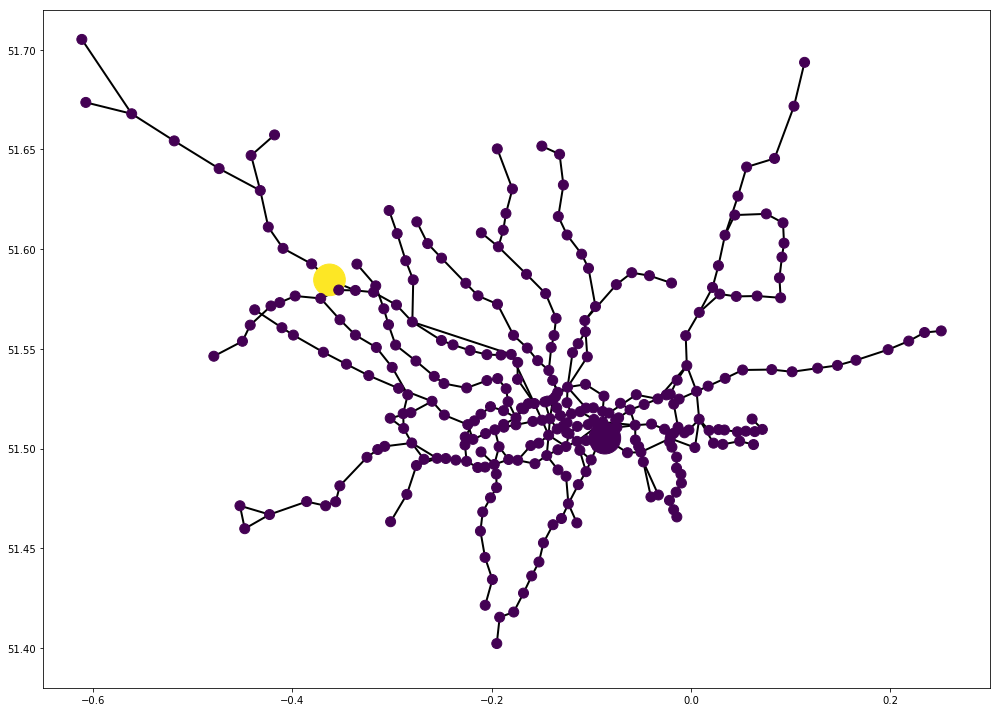

In [49]:
generate_animation(A, 100, 500, 184, 157)

In [51]:
plt.imshow(pheromones)

NameError: name 'pheromones' is not defined

In [291]:
N_ants = 1000

ants, pheromones, possible_moves, paths_home = initialise_world(A, N_ants, 184, 157)

for _ in range(100):
    ants, pheromones = advance_world(ants, pheromones, possible_moves, paths_home)
    
    
    
antpos = [[ant.position for ant in ants].count(i) for i in range(A.shape[0])]
# # nx.draw_networkx_nodes(G, pos=pos, node_color=node_colours, node_size=[max(100, 50*i) for i in antpos])
# # nx.draw_networkx_edges(G, pos=pos, width=[5*i for i in nx.get_edge_attributes(G, "weight").values()])
# nx.draw_networkx_nodes(G, pos=pos, node_color=node_colours, node_size=[max(100, 50*i) for i in antpos])
# nx.draw_networkx_edges(G, pos=pos, width=5, edge_color=[10*i for i in nx.get_edge_attributes(G, "pheromones").values()])



/Users/qcaudron/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in double_scalars


In [292]:
antpos

[0,
 4,
 0,
 0,
 0,
 0,
 33,
 2,
 1,
 0,
 0,
 14,
 1,
 0,
 1,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 4,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 20,
 0,
 2,
 56,
 1,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 1,
 9,
 8,
 27,
 5,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 5,
 2,
 1,
 0,
 0,
 3,
 1,
 6,
 3,
 0,
 3,
 6,
 0,
 6,
 4,
 0,
 5,
 0,
 7,
 0,
 0,
 4,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 32,
 0,
 1,
 0,
 0,
 3,
 0,
 0,
 4,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 6,
 1,
 9,
 4,
 1,
 1,
 0,
 1,
 2,
 5,
 0,
 0,
 0,
 0,
 0,
 21,
 0,
 3,
 0,
 0,
 2,
 2,
 3,
 0,
 0,
 1,
 88,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 2,
 25,
 1,
 48,
 2,
 0,
 0,
 24,
 0,
 8,
 0,
 1,
 0,
 3,
 1,
 6,
 3,
 18,
 1,
 3,
 5,
 1,
 3,
 0,
 0,
 3,
 1,
 1,
 0,
 4,
 13,
 2,
 4,
 5,
 0,
 5,
 1,
 1,
 0,
 0,
 0,
 3,
 0,
 46,
 1,
 1,
 1,
 4,
 0,
 4,
 3,
 2,
 1,
 0,
 0,
 0,
 0,
 7,
 18,
 4,
 0,
 0,
 5,
 1,
 0,
 2,
 10,
 0,
 2,

In [374]:
nx.get_edge_attributes(G2, "weight").values()

dict_values([0.001797029583659551, 0.0016173266252935959, 0.0014555939627642362, 0.0013100345664878127])

In [188]:
paths_home

NameError: name 'paths_home' is not defined